In [27]:
import numpy as np
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch

In [2]:
train_df = pd.read_csv("../data/train.csv")
valid_df = pd.read_csv("../data/valid.csv")
train_df.head()

,Unnamed: 0,text,label
0,94625,The Maltese Falcon film noir based on the nove...,1
1,89585,Water is a scarce resource so when it is dispe...,1
2,187840,I was really expecting a lot given all the hyp...,1
3,265694,"This movie was just awful. It was not scary, t...",0
4,125407,"""The Town"" is an excellent film that does have...",0


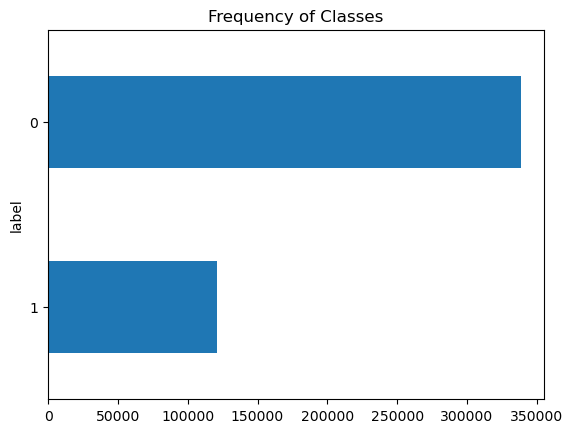

In [3]:
train_df["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

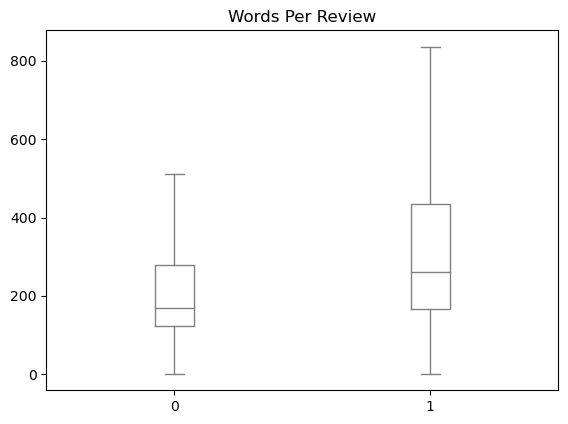

In [4]:
train_df["Words Per Review"] = train_df["text"].str.split().apply(len)
train_df.boxplot("Words Per Review", by="label", grid=False, showfliers=False,
           color="gray")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [5]:
train_df.drop(['Words Per Review'], axis=1, inplace=True)

In [6]:
train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)
train_ds,valid_ds

(Dataset({
     features: ['Unnamed: 0', 'text', 'label'],
     num_rows: 459130
 }),
 Dataset({
     features: ['Unnamed: 0', 'text', 'label'],
     num_rows: 114783
 }))

In [7]:
model_ckpt = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [8]:
encoded_text = tokenizer(train_df["text"][0])
encoded_text

Token indices sequence length is longer than the specified maximum sequence length for this model (589 > 512). Running this sequence through the model will result in indexing errors


{'input_ids': [0, 133, 24694, 4468, 16289, 822, 117, 853, 716, 15, 5, 5808, 9, 5, 276, 1270, 30, 18946, 324, 890, 24782, 2645, 4, 33038, 196, 30, 610, 31112, 261, 6, 405, 1575, 16788, 5460, 14380, 2013, 25, 940, 13660, 1960, 2064, 1829, 8, 2708, 8937, 368, 25, 39, 22, 506, 991, 1794, 5886, 1627, 113, 3653, 4, 15151, 2459, 1655, 6, 2155, 12235, 241, 6, 8, 4290, 1628, 20521, 1029, 12, 3641, 11, 762, 3117, 4502, 4, 133, 527, 3905, 10, 764, 2659, 940, 14104, 8, 39, 18380, 19, 130, 21219, 35361, 45583, 6, 70, 9, 2661, 32, 5468, 7, 6925, 10, 24693, 12, 225, 8344, 15876, 14848, 3865, 12377, 257, 3398, 4, 21169, 2064, 1829, 16, 10, 543, 12, 3983, 6691, 764, 2659, 940, 2295, 54, 64, 28, 25, 21219, 35361, 25, 5, 220, 2173, 53, 67, 2329, 29492, 7, 39, 308, 1081, 3260, 9, 3712, 4, 20693, 5, 4088, 9, 5, 2064, 1829, 359, 19697, 14104, 1218, 34752, 10, 4523, 15133, 352, 6, 54, 1523, 10, 739, 5494, 22022, 7, 1960, 8, 39, 1784, 11815, 19697, 114, 51, 581, 1744, 69, 31, 951, 1440, 13400, 20074, 1409, 4,

In [9]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [10]:
train_encoded = train_ds.map(tokenize, batched=True, batch_size=1024)

Parameter 'function'=<function tokenize at 0x28a4e31c0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/449 [00:00<?, ?ba/s]

In [11]:
valid_encoded = valid_ds.map(tokenize, batched=True, batch_size=1024)

  0%|          | 0/113 [00:00<?, ?ba/s]

In [19]:
valid_encoded

Dataset({
    features: ['Unnamed: 0', 'text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 114783
})

In [12]:
train_encoded

Dataset({
    features: ['Unnamed: 0', 'text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 459130
})

In [13]:
device = torch.device("mps")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
from huggingface_hub import notebook_login

notebook_login()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(train_encoded) // batch_size
model_name = f"{model_ckpt}-finetuned-imdb-spoilers"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=train_encoded,
                  eval_dataset=valid_encoded,
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss
